In [1]:
from pathlib import Path
from corpus_unpdf.utils import get_sc_pdf_from_id
# db = Path().cwd().parent / "corpus-extractor" / "links.db"
# target_file = get_sc_pdf_from_id(db, 227600)

In [2]:
target_file = Path().cwd() / "data" / "data1.pdf"

Executing <Task pending name='Task-3' coro=<Kernel.dispatch_queue() running at /Users/mv/Code/corpus-unpdf/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py:512> wait_for=<Future pending cb=[Task.task_wakeup()] created at /Users/mv/Code/corpus-unpdf/.venv/lib/python3.11/site-packages/tornado/queues.py:248> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/mv/Code/corpus-unpdf/.venv/lib/python3.11/site-packages/tornado/ioloop.py:687] created at /Users/mv/.pyenv/versions/3.11.1/lib/python3.11/asyncio/tasks.py:670> took 0.270 seconds


In [3]:
target_file

PosixPath('/Users/mv/Code/corpus-unpdf/data/data1.pdf')

In [4]:
import cv2
from PIL import Image
import pytesseract
from corpus_unpdf import get_img
ROI = "temp/roi.png"
PAGE_NUM = 0
PDF = Path().cwd() / "data" / "data1.pdf"
im = get_img(target_file, pagenum=PAGE_NUM)

In [5]:
import numpy
opencvImage = cv2.cvtColor(numpy.array(im), cv2.COLOR_RGB2BGR)
base_image = opencvImage.copy()
im_h, im_w, im_d = opencvImage.shape

Executing <Task pending name='Task-3' coro=<Kernel.dispatch_queue() running at /Users/mv/Code/corpus-unpdf/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py:512> wait_for=<Future pending cb=[Task.task_wakeup()] created at /Users/mv/Code/corpus-unpdf/.venv/lib/python3.11/site-packages/tornado/queues.py:248> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/mv/Code/corpus-unpdf/.venv/lib/python3.11/site-packages/tornado/ioloop.py:687] created at /Users/mv/.pyenv/versions/3.11.1/lib/python3.11/asyncio/tasks.py:670> took 1.040 seconds


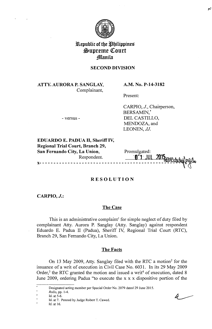

In [6]:
width, height = im.size
im.resize((width//12, height//12))

In [8]:
from corpus_unpdf.images.pdf_lines import get_contours
im_h, im_w, _ = opencvImage.shape
partial = opencvImage[2118+100:2118+300,]
for c in get_contours(partial, (30, 10)):
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(opencvImage, (x,y), (x+w, y+h), (36, 255, 12), 3)
cv2.imwrite("temp/sample_boxes.png", partial)

True

In [ ]:
import pdfplumber
pdf = pdfplumber.open(PDF)
page = pdf.pages[0]
page.crop(
  bbox=(0, page.height * start_decision_bottom, page.width, page.height),
  relative=False,
  strict=True,
).to_image()

In [ ]:
if footnote_top:
  page.crop(
    bbox=(0, (page.height * footnote_top) + 5, page.width, page.height * 0.938),
    relative=False,
    strict=True,
  ).to_image()

In [ ]:
from PIL import Image
try: # roi found
    cv2.imwrite(ROI, roi)
    ocr_result = pytesseract.image_to_string(roi)
    pilimg = Image.open(ROI)
    pilimg.save(
        "temp/temp.pdf", "PDF" ,resolution=100.0, save_all=True
    )	
    print("Reveal ROI")    

except NameError: # no roi, just remove header
    cv2.imwrite(ROI, base_image)
    ocr_result = pytesseract.image_to_string(base_image[HEADER_TOP:im_h, 0:im_w])
    pilimg = Image.open(ROI)
    pilimg.save(
        "temp/temp.pdf", "PDF" ,resolution=300.0, save_all=True
    )	
    print("Reveal base")


In [ ]:
ocr_result

In [ ]:
import pdfplumber
pdf = pdfplumber.open("temp/temp.pdf")

In [ ]:
pdf.pages[0].extract_text()